pip install --user colour-demosaicing# Image Sensing Pipeline

# In this homework ……

In [1]:
import os
import cv2
import math
import random
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# 1. Camera  Parameters

## 1.1 Import Data from tone_curves

In [2]:
curve_path = './'
curve_name = os.path.join(curve_path, 'tone_curves.mat')
curve_inv_name = os.path.join(curve_path, 'tone_curves_inv.mat')
tone_curves = scipy.io.loadmat(curve_name)
tone_curves_inv = scipy.io.loadmat(curve_inv_name)

In [3]:
I = tone_curves['I'] # Irradiance 輻照度: 電磁輻射入射於曲面時每單位面積的功率。
B = tone_curves['B'] # Brightness 亮度
I_inv = tone_curves_inv['invI']
B_inv = tone_curves_inv['invB']

Text(0.5, 1.0, 'Brightness')

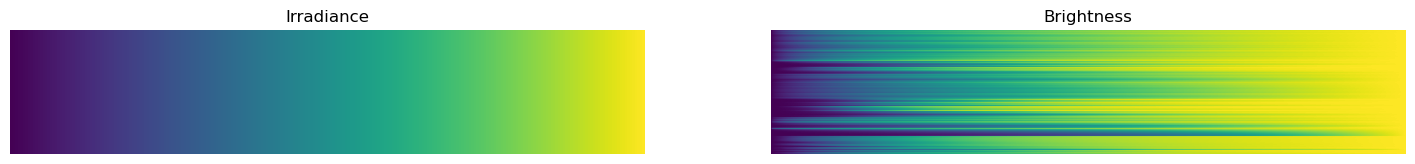

In [4]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(I)
plt.title('Irradiance')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(B)
plt.title('Brightness')

In [5]:
# Tone Curves Parameters
tone_index = 170
B[tone_index]

array([0.000000e+00, 5.767133e-05, 1.163159e-04, ..., 9.956537e-01,
       9.978255e-01, 1.000000e+00], dtype=float32)

## 1.2 Color Correction Matrix

In [6]:
ccm = np.array([1.0234, -0.2969, -0.2266, 
                -0.5625, 1.6328, -0.0469, 
                -0.0703, 0.2188, 0.6406])
ccm = np.reshape(ccm, (3, 3))
ccm = (ccm / np.tile(np.sum(ccm, axis=1), [3, 1]).T).T
ccm_inv = np.linalg.inv(np.copy(ccm))

## 1.3 White Balance

In [7]:
# White Balance Parameters
fr = 0.7715567349551743
fb = 0.9068480239589546

# 2.  Load Image

In [8]:
def BGR2RGB(img):
    """
    Convert BGR image to RGB format.
    
    Parameters:
    - img: numpy array representing the BGR image
    
    Returns:
    - rgb_img: numpy array representing the RGB image
    """
    # Swap the red and blue channels
    rgb_img = img[:, :, ::-1]
    return rgb_img

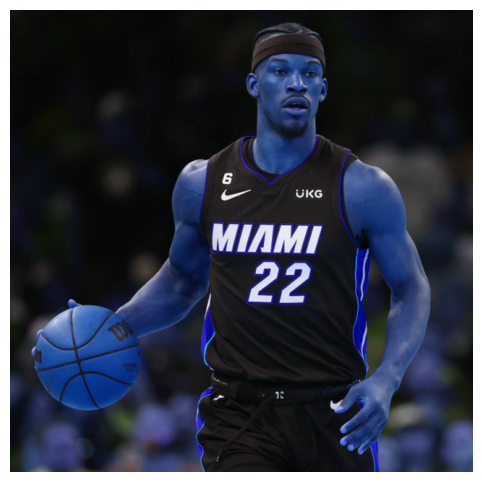

In [9]:
img = cv2.imread('nba.png')
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.imshow(img)

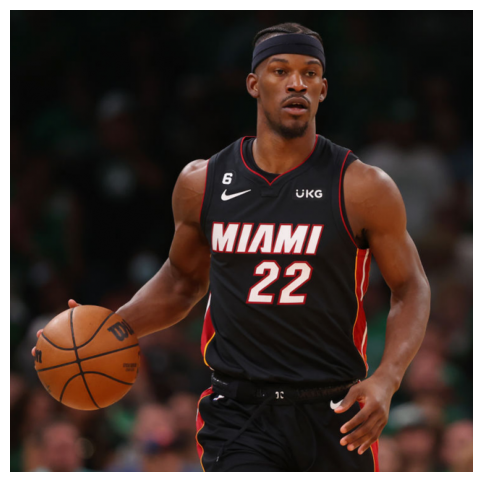

In [10]:
img = cv2.imread('nba.png')
np.array(img, dtype='uint8')
img = img.astype('double') / 255.0
img_gt = img
#### Remember that the image store in OpenCV is BGR instead of RGB
#### We should transfer to RGB first before ISP
plt.figure(figsize=(12, 6))
img = BGR2RGB(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

# 3. Inverse ISP Process

## 3.1 Tone Mapping

In [11]:
import numpy as np
import math

def tone_mapping(img, I, B, index=0, inv=False):
    '''
    Input:
        img: H*W*3 numpy array, input image.
        I: 201*1024 array, represents 201 tone curves for Irradiance.
        B: 201*1024 array, represents 201 tone curves for Brightness.
        index: int, choose which curve to use, default is 0
        inv: bool, judge whether tone mapping (False) or inverse tone mapping (True), default is False
    Output:
        output: H*W*3 numpy array, output image after (inverse) tone mapping.
    '''
    ########################################################################
    # TODO:                                                                #
    #   Following above instruction to get tone mapping as output.         #
    #   and inverse tone mapping result as output                          #
    ########################################################################
    if inv == True:
        output = np.interp(img.ravel(),B[index],I[index])
    elif inv == False:
        output = np.interp(img.ravel(),I[index],B[index])
    output = output.reshape(img.shape)
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################

    return output


In [12]:
img_inverse_tone = tone_mapping(img, I_inv, B_inv, index=tone_index, inv=True)

Text(0.5, 1.0, 'Image after inverse tone')

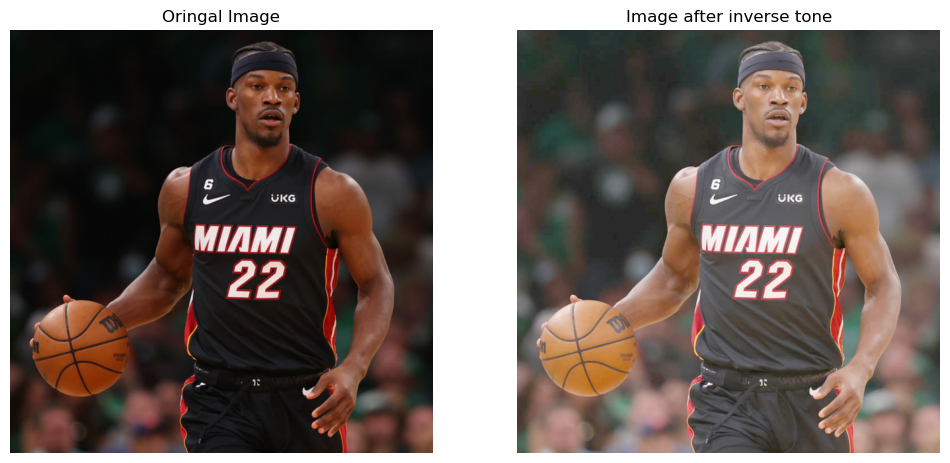

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img_inverse_tone)
plt.title('Image after inverse tone')

## 3.2 from RGB to CIE XYZ
The CIE XYZ color space is a more universal color representation method that is independent of device characteristics and closer to the perception of the **human visual system**. The CIE XYZ color space is composed of three color components: X, Y, and Z. Among these, X and Y represent the **brightness** and **saturation** of the color, while Z represents the **hue** of the color.

<img style="float: left;" src="./images/3.jpg" width="60%">

In [14]:
def RGB2XYZ(rgb_img):
    """
    Convert RGB image to XYZ format.
    
    Parameters:
    - rgb_img: numpy array representing the RGB image
    
    Returns:
    - xyz_img: numpy array representing the XYZ image
    """
    # Convert the image to double
    rgb_img = rgb_img.astype('double')

    # Convert from [0, 1] to [0, 255]
    rgb_img *= 255.0

    # Normalize the RGB values
    rgb_img /= 255.0

    # Conversion matrix
    conversion_matrix = np.array([[0.4124564, 0.3575761, 0.1804375],
                                  [0.2126729, 0.7151522, 0.0721750],
                                  [0.0193339, 0.1191920, 0.9503041]])

    # Reshape image to a vector for matrix multiplication
    reshaped_img = np.reshape(rgb_img, (-1, 3))

    # Matrix multiplication to get XYZ values
    xyz_img = np.dot(reshaped_img, conversion_matrix.T)

    # Reshape back to original shape
    xyz_img = np.reshape(xyz_img, rgb_img.shape)

    return xyz_img

#from color_correction import RGB2XYZ
img_inverse_tone_XYZ = RGB2XYZ(img_inverse_tone)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after CIE')

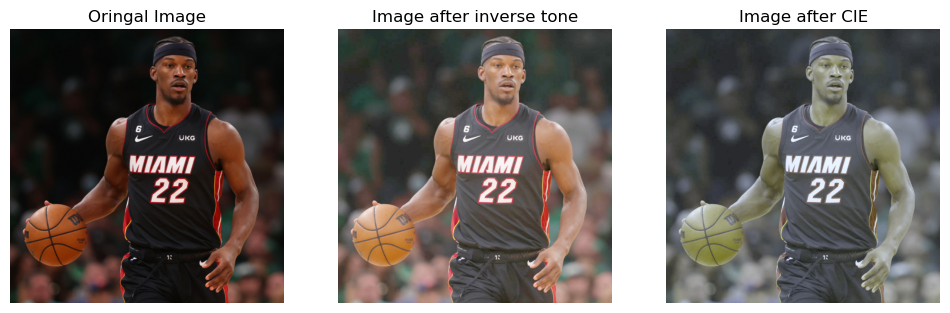

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_inverse_tone)
plt.title('Image after inverse tone')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(img_inverse_tone_XYZ)
plt.title('Image after CIE')

## 3.3. Color Correction

In [16]:
import numpy as np

def color_correction(img, ccm):
    '''
    Input:
        img: H*W*3 numpy array, input image
        ccm: 3*3 numpy array, color correction matrix 
    Output:
        output: H*W*3 numpy array, output image after color correction
    '''
    ########################################################################
    # TODO:                                                                #
    #   Following above instruction to get color correction result         #
    #                                                                      #
    ########################################################################
    
   
    # Apply color correction by matrix multiplication: output = img * ccm
    output = img.dot(ccm)
    # Prevent the value larger than 1 or less than 0
    output = np.clip(output, 0, 1)
    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    
    
    
    return output


In [17]:
ccm

array([[ 2.04720944, -0.54963846, -0.08908884],
       [-0.59391878,  1.59546609,  0.27727791],
       [-0.45329066, -0.04582763,  0.81181092]])

In [18]:
img_inverse_ccm = color_correction(img_inverse_tone_XYZ, ccm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after CCM')

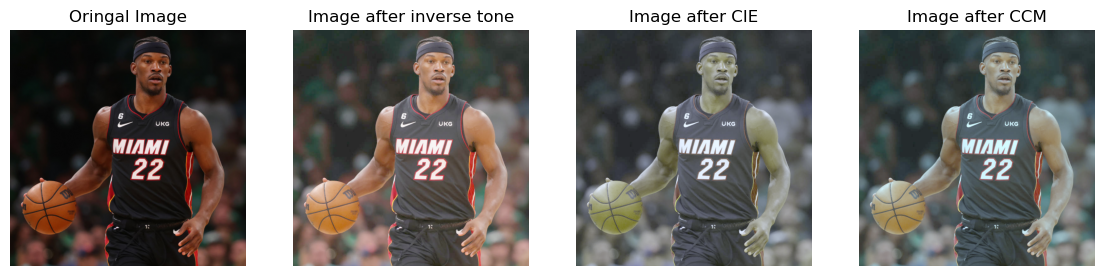

In [19]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(img_inverse_tone)
plt.title('Image after inverse tone')
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(img_inverse_tone_XYZ)
plt.title('Image after CIE')
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(img_inverse_ccm)
plt.title('Image after CCM')

## 3.4 Mosaic

In [20]:
import os
from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007,
    mosaicing_CFA_Bayer)

In [21]:
import numpy as np

def mosaic(img, pattern):
    '''
    Input:
        img: H*W*3 numpy array, input image.
        pattern: string, 4 different Bayer patterns (GRBG, RGGB, GBRG, BGGR)
    Output:
        output: H*W numpy array, output image after mosaic.
    '''
    # Create the H*W output numpy array
    output = np.zeros_like(img[:, :, 0])

    ########################################################################
    # TODO:                                                                #
    #   1. Discard other two channels from input 3-channel image according #
    #      to given Bayer pattern.                                         #
    #                                                                      #
    #   e.g. If Bayer pattern now is BGGR, for the upper left pixel from   #
    #        each four-pixel square, we should discard R and G channel     #
    #        and keep B channel of input image.                            #     
    #        (since upper left pixel is B in BGGR bayer pattern)           #
    ########################################################################
    
    # if pattern == 'GRBG':
    #     # Green in upper left
    #     output[::2, ::2] = img[::2, ::2, 1]  # Green
    #     # Red in upper right
    #     output[::2, 1::2] = img[::2, 1::2, 0]  # Red
    #     # Blue in lower left
    #     output[1::2, ::2] = img[1::2, ::2, 2]  # Blue
    #     # Green in lower right
    #     output[1::2, 1::2] = img[1::2, 1::2, 1]  # Green
        
    # elif pattern == 'RGGB':
    #     # Red in upper left
    #     output[::2, ::2] = img[::2, ::2, 0]  # Red
    #     # Green in upper right
    #     output[::2, 1::2] = img[::2, 1::2, 1]  # Green
    #     # Green in lower left
    #     output[1::2, ::2] = img[1::2, ::2, 1]  # Green
    #     # Blue in lower right
    #     output[1::2, 1::2] = img[1::2, 1::2, 2]  # Blue
        
    # elif pattern == 'GBRG':
    #     # Green in upper left
    #     output[::2, ::2] = img[::2, ::2, 1]  # Green
    #     # Blue in upper right
    #     output[::2, 1::2] = img[::2, 1::2, 2]  # Blue
    #     # Red in lower left
    #     output[1::2, ::2] = img[1::2, ::2, 0]  # Red
    #     # Green in lower right
    #     output[1::2, 1::2] = img[1::2, 1::2, 1]  # Green
        
    # elif pattern == 'BGGR':
    #     # Blue in upper left
    #     output[::2, ::2] = img[::2, ::2, 2]  # Blue
    #     # Green in upper right
    #     output[::2, 1::2] = img[::2, 1::2, 1]  # Green
    #     # Green in lower left
    #     output[1::2, ::2] = img[1::2, ::2, 1]  # Green
    #     # Red in lower right
    #     output[1::2, 1::2] = img[1::2, 1::2, 0]  # Red
    output = mosaicing_CFA_Bayer(img, pattern)
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################

    return output

In [22]:
#from demosaic_and_mosaic import mosaic, demosaic
pattern='RGGB'
img_mosaic = mosaic(img_inverse_ccm, pattern=pattern)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after mosaic')

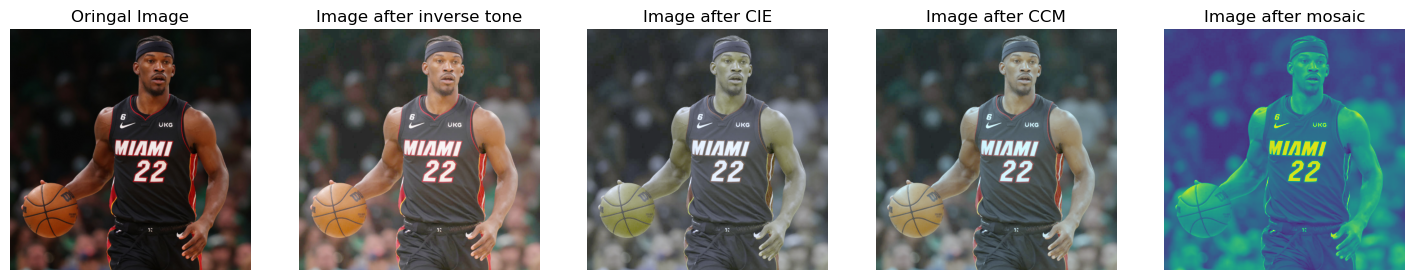

In [23]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 5, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 5, 2)
plt.axis('off')
plt.imshow(img_inverse_tone)
plt.title('Image after inverse tone')
plt.subplot(1, 5, 3)
plt.axis('off')
plt.imshow(img_inverse_tone_XYZ)
plt.title('Image after CIE')
plt.subplot(1, 5, 4)
plt.axis('off')
plt.imshow(img_inverse_ccm)
plt.title('Image after CCM')
plt.subplot(1, 5, 5)
plt.axis('off')
plt.imshow(img_mosaic)
plt.title('Image after mosaic')

## 3.5 Inverse AWB
1. Create a numpy array with shape of input RAW image.
2. According to the given Bayer pattern, fill the fr into  correspinding red channel position and fb into correspinding  blue channel position. Fill 1 into green channel position otherwise.  

In [24]:
import numpy as np

def generate_wb_mask(img, pattern, fr, fb):
    '''
    Input:
        img: H*W numpy array, RAW image
        pattern: string, 4 different Bayer patterns (GRBG, RGGB, GBRG, BGGR)
        fr: float, white balance factor of red channel
        fb: float, white balance factor of blue channel 
    Output:
        mask: H*W numpy array, white balance mask
    '''
    ########################################################################
    # TODO:                                                                #
    #   1. Create a numpy array with shape of input RAW image.             #
    #   2. According to the given Bayer pattern, fill the fr into          #
    #      corresponding red channel position and fb into corresponding    #
    #      blue channel position. Fill 1 into green channel position       #
    #      otherwise.                                                      #
    ########################################################################

    # Extract image dimensions
    H, W = img.shape

    # Initialize white balance mask with the same dimensions as the input image
    mask = np.ones((H, W))

    # Create masks for each Bayer pattern
    if pattern == 'GRBG':
        mask[::2, ::2] = fr  # Red channel
        mask[1::2, 1::2] = fb  # Blue channel
    elif pattern == 'RGGB':
        mask[1::2, 1::2] = fr  # Red channel
        mask[1::2, ::2] = fb  # Blue channel
    elif pattern == 'GBRG':
        mask[1::2, ::2] = fr  # Red channel
        mask[::2, 1::2] = fb  # Blue channel
    elif pattern == 'BGGR':
        mask[::2, 1::2] = fr  # Red channel
        mask[1::2, ::2] = fb  # Blue channel
    else:
        raise ValueError("Invalid Bayer pattern")

    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
        
    return mask


In [25]:
fr = 0.7715567349551743
fb = 0.9068480239589546
wb_mask = generate_wb_mask(img_mosaic, pattern, fr, fb)
img_Inverse_WB = img_mosaic  * wb_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after Inverse WB')

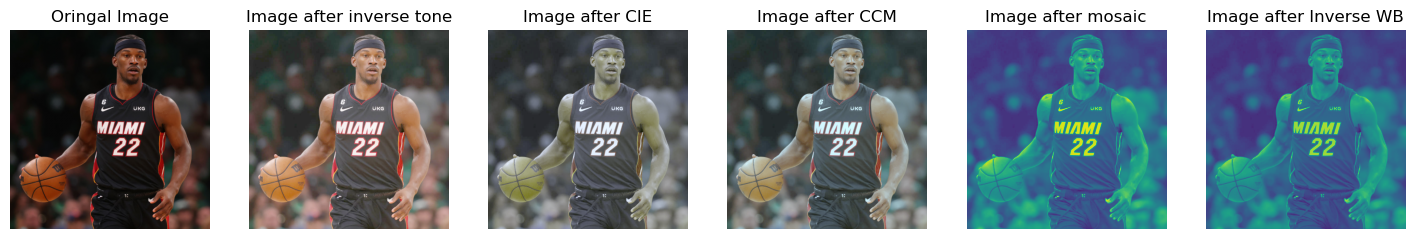

In [26]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 6, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 6, 2)
plt.axis('off')
plt.imshow(img_inverse_tone)
plt.title('Image after inverse tone')
plt.subplot(1, 6, 3)
plt.axis('off')
plt.imshow(img_inverse_tone_XYZ)
plt.title('Image after CIE')
plt.subplot(1, 6, 4)
plt.axis('off')
plt.imshow(img_inverse_ccm)
plt.title('Image after CCM')
plt.subplot(1, 6, 5)
plt.axis('off')
plt.imshow(img_mosaic)
plt.title('Image after mosaic')
plt.subplot(1, 6, 6)
plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('Image after Inverse WB')

# 4. ISP Process

## 4.1 AWB

In [27]:
wb_mask = generate_wb_mask(img_Inverse_WB, pattern, 1/fr, 1/fb)
img_WB = img_Inverse_WB * wb_mask
img_WB = np.clip(img_WB, 0, 1)

Text(0.5, 1.0, 'Image after WG')

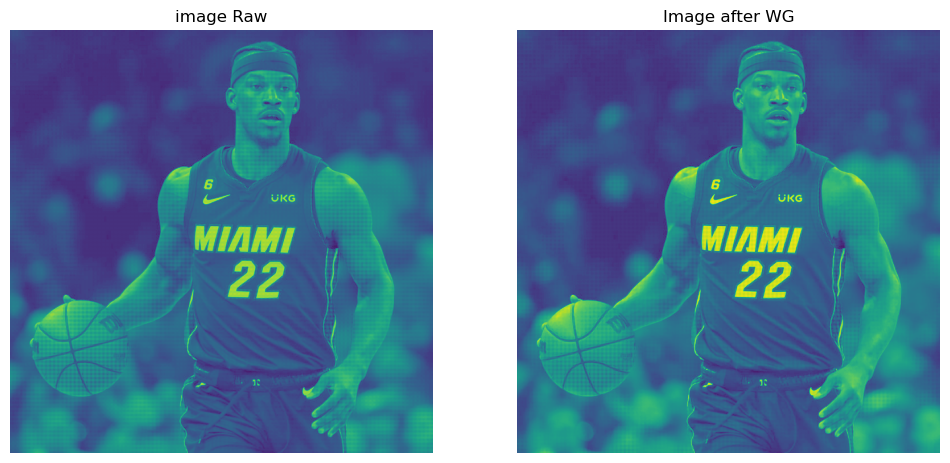

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1);plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('image Raw')
plt.subplot(1, 2, 2);plt.axis('off')
plt.imshow(img_WB)
plt.title('Image after WG')

## 4.2 Demosaic

In [29]:
def demosaic(img, pattern):
    '''
    Input:
        img: H*W numpy array, input mosaic image.
        pattern: string, 4 different Bayer patterns (GRBG, RGGB, GBRG, BGGR)
    Output:
        output: H*W*3 numpy array, output image after demosaic.
    '''
    ########################################################################
    # TODO:                                                                #
    #   1. Fill in the missing color channels for each pixel based on the #
    #      Bayer pattern.                                                  #
    #                                                                      #
    #   e.g. If Bayer pattern is BGGR, for the upper left pixel from each  #
    #        four-pixel square, we should interpolate R and G channel      #
    #        values from neighboring pixels.                               #
    ########################################################################
    # implement the demosaic function
    # Create the H*W*3 output numpy array
    H, W = img.shape
    output = np.zeros((H, W, 3))

    # output = demosaicing_CFA_Bayer_bilinear(img, pattern)
    output = demosaicing_CFA_Bayer_Menon2007(img, pattern)

    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
  
    return output


In [30]:
img_demosaic = demosaic(img_WB, pattern=pattern) #pattern='RGGB'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after demosaic')

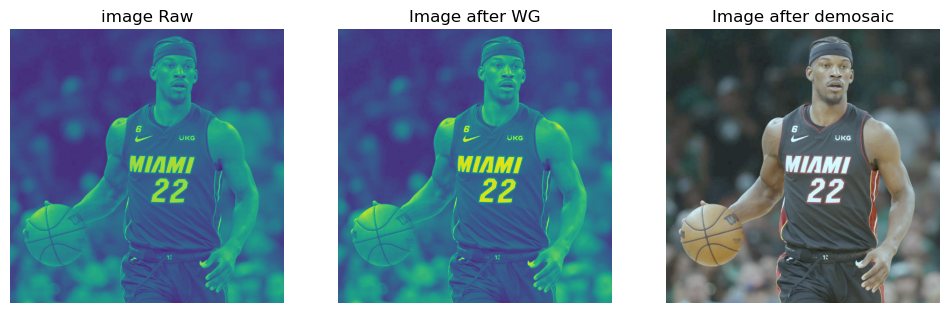

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1);plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('image Raw')
plt.subplot(1, 3, 2);plt.axis('off')
plt.imshow(img_WB)
plt.title('Image after WG')
plt.subplot(1, 3, 3);plt.axis('off')
plt.imshow(img_demosaic)
plt.title('Image after demosaic')

## 4.3 Color Correction

In [32]:
img_color_correction = color_correction(img_demosaic, ccm_inv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after Color Correction')

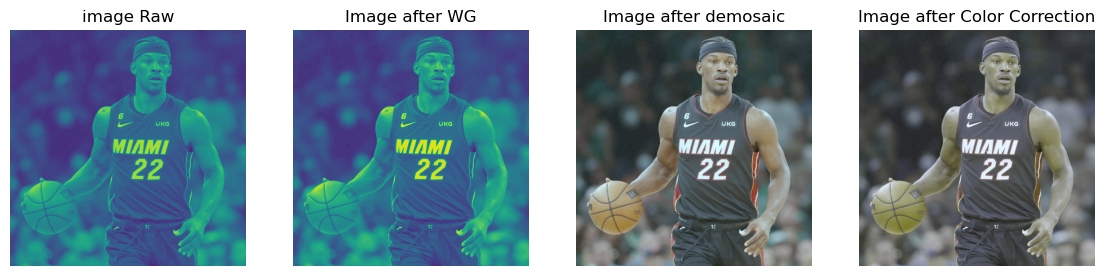

In [33]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1);plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('image Raw')
plt.subplot(1, 4, 2);plt.axis('off')
plt.imshow(img_WB)
plt.title('Image after WG')
plt.subplot(1, 4, 3);plt.axis('off')
plt.imshow(img_demosaic)
plt.title('Image after demosaic')
plt.subplot(1, 4, 4);plt.axis('off')
plt.imshow(img_color_correction)
plt.title('Image after Color Correction')

## 4.4 XYZ2RGB

In [34]:
import numpy as np

def XYZ2RGB(xyz):
    '''
    Input:
        xyz: H*W*3 numpy array, input image in XYZ color space.
    Output:
        rgb: H*W*3 numpy array, output image in RGB color space.
    '''
    ########################################################################
    # TODO:                                                                #
    #   Implement the XYZ to RGB conversion.                               #
    ########################################################################
    
    # Define the transformation matrix from XYZ to RGB (sRGB D65)
    M = np.array([[ 3.2404542, -1.5371385, -0.4985314],
                  [-0.9692660,  1.8760108,  0.0415560],
                  [ 0.0556434, -0.2040259,  1.0572252]])
    
    # Reshape the input XYZ values if needed
    if len(xyz.shape) == 2:
        xyz = xyz.reshape(-1, 3)
    
    # Apply the transformation: RGB = XYZ * M
    rgb = np.dot(xyz, M.T)
    
    # Clip the RGB values to ensure they are within the valid range [0, 1]
    rgb = np.clip(rgb, 0, 1)
    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    
    return rgb

img_RGB = XYZ2RGB(img_color_correction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after XYZ2RGB')

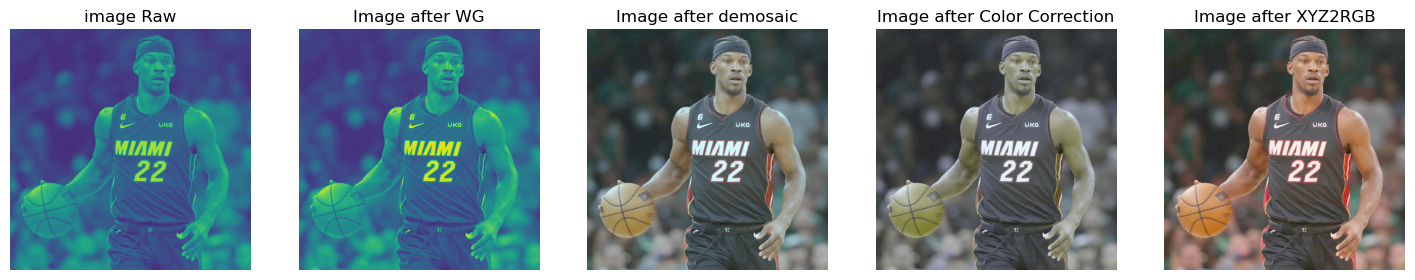

In [35]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 5, 1);plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('image Raw')
plt.subplot(1, 5, 2);plt.axis('off')
plt.imshow(img_WB)
plt.title('Image after WG')
plt.subplot(1, 5, 3);plt.axis('off')
plt.imshow(img_demosaic)
plt.title('Image after demosaic')
plt.subplot(1, 5, 4);plt.axis('off')
plt.imshow(img_color_correction)
plt.title('Image after Color Correction')
plt.subplot(1, 5, 5);plt.axis('off')
plt.imshow(img_RGB)
plt.title('Image after XYZ2RGB')

## 4.5 tone_mapping

In [36]:
img_tm = tone_mapping(img_RGB, I, B, index=tone_index, inv=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image after tone mapping')

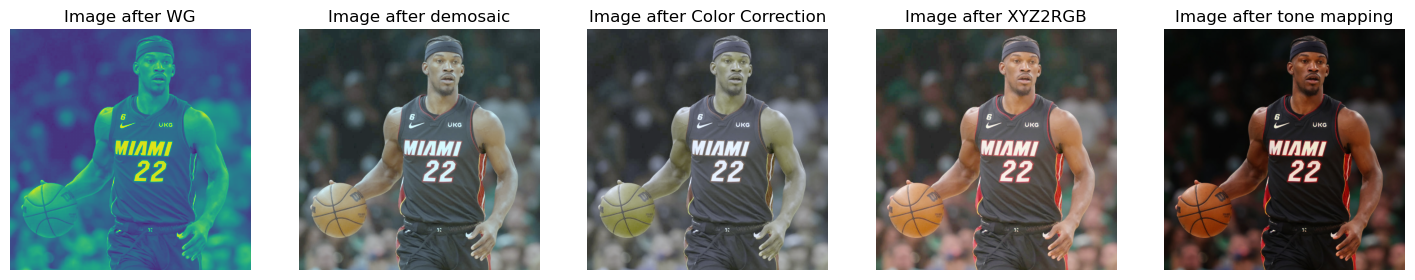

In [37]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 5, 1);plt.axis('off')
plt.imshow(img_WB)
plt.title('Image after WG')
plt.subplot(1, 5, 2);plt.axis('off')
plt.imshow(img_demosaic)
plt.title('Image after demosaic')
plt.subplot(1, 5, 3);plt.axis('off')
plt.imshow(img_color_correction)
plt.title('Image after Color Correction')
plt.subplot(1, 5, 4);plt.axis('off')
plt.imshow(img_RGB)
plt.title('Image after XYZ2RGB')
plt.subplot(1, 5, 5);plt.axis('off')
plt.imshow(img_tm)
plt.title('Image after tone mapping')

Text(0.5, 1.0, 'ISP result')

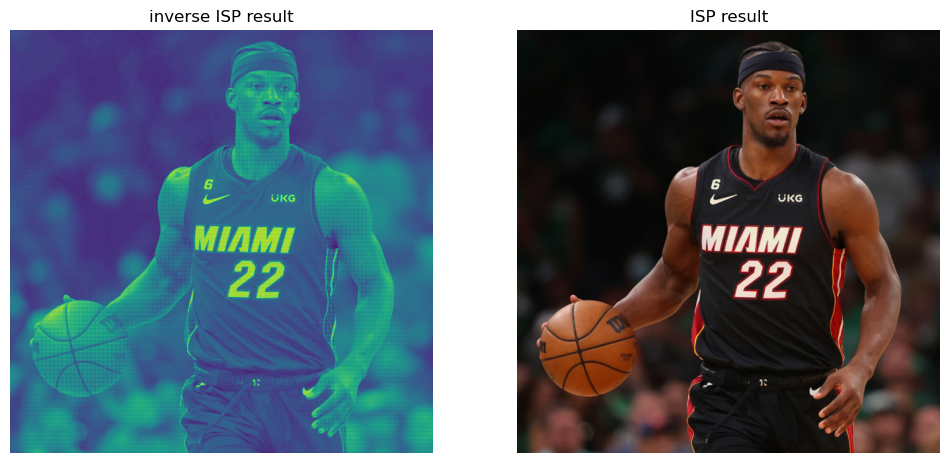

In [38]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);plt.axis('off')
plt.imshow(img_Inverse_WB)
plt.title('inverse ISP result')
plt.subplot(1, 2, 2);plt.axis('off')
plt.imshow(img_tm)
plt.title('ISP result')

Text(0.5, 1.0, 'Image after inverse process')

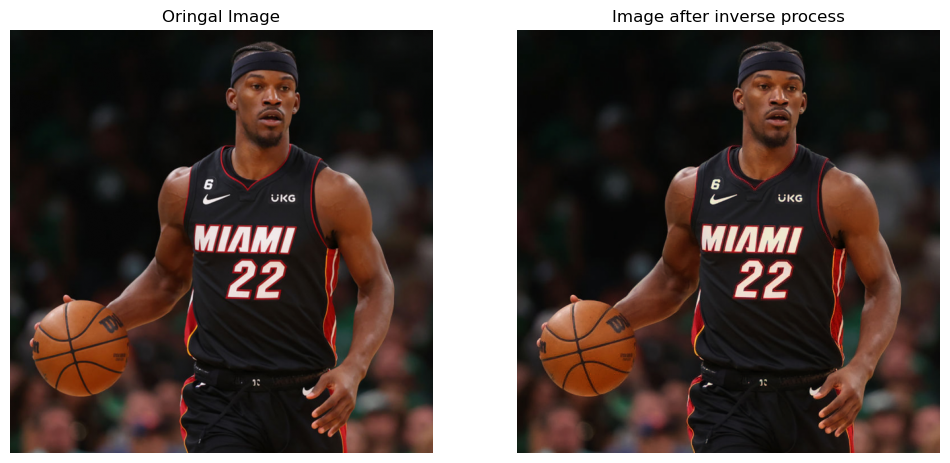

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1);plt.axis('off')
plt.imshow(img)
plt.title('Oringal Image')
plt.subplot(1, 2, 2);plt.axis('off')
plt.imshow(img_tm)
plt.title('Image after inverse process')

## Peak signal-to-noise ratio
峰值信噪比（英語：Peak signal-to-noise ratio，常縮寫為PSNR）是一個表示信號最大可能功率和影響它的表示精度的破壞性雜訊功率的比值的工程術語。由於許多信號都有非常寬的動態範圍，峰值信噪比常用對數分貝單位來表示。峰值信噪比經常用作圖像壓縮等領域中信號重建質量的測量方法，它常簡單地通過均方誤差（MSE）進行定義。兩個m×n單色圖像I和K，如果一個為另外一個的噪聲近似，那麼它們的的均方誤差定義如下圖:

對於每點有RGB三個值的彩色圖像來說峰值信噪比的定義類似，只是均方誤差是所有方差之和除以圖像尺寸再除以 3。圖像壓縮中典型的峰值信噪比值在 30 到 40dB 之間，**愈高愈好**。

In [40]:
def calculate_psnr(img1, img2):
    '''
    Input:
        img1, img2: H*W*3 numpy array
    Output:
        psnr: the peak signal-to-noise ratio value
    '''
    ########################################################################
    # TODO:                                                                #
    #   Following above instruction to get PSNR as output.                 #
    #                                                                      #
    ########################################################################
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    

    
    ########################################################################
    #                                                                      #
    #                           End of your code                           #
    #                                                                      # 
    ########################################################################
    return psnr

In [41]:
calculate_psnr(img, img_tm)

36.280036940218814